# Predict

**INPUT**: You can try any model in "./models/" (for example best_xgb_model.json) and any new data the model was not trained on "./data/all/aus_open_2025_new.csv". Alternatively, you can just predict individual matches.

**OUTPUT**: Predictions of matches

In [84]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import re
import pickle
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from utils.updateStats import getStats, updateStats, createStats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.tri as mtri
pd.set_option('display.max_columns', None)

## Re-Calculate all the stats

Firstly, we need to re-calculate all the stats. I could have export this in 1.CreateDataset, but I thought it would be better if I did it here again for simplicity (instead of export the statistics, which might weight a lot).

This is fairly okay, since it only takes a minute on my machine. Obviosly, if it took longer, I would directly export all the stats in 1.CreateDataset instead of doing this.

In [70]:
clean_data = pd.read_csv("./data/0cleanDataset.csv")
prev_stats = createStats()

# Iterate through each row in clean_data
for index, row in tqdm(clean_data.iterrows(), total=len(clean_data)):
    ########## UPDATE STATS ##########
    # We only need to update the stats, since we don't need to create a dataset
    prev_stats = updateStats(row, prev_stats)

100%|██████████| 41689/41689 [00:13<00:00, 3039.32it/s]


## Predict Any Two Players

In [3]:
# Load the model from models
xgb_model = XGBClassifier()
xgb_model.load_model("./models/xgb_model.json")

# I define this here to make the results more easy to interpret
mapper = np.vectorize(lambda x: "Player 2 Wins" if x == 0 else "Player 1 Wins")

Here, I'm going to predict a match between Sinner and Alcaraz. I'm going to simulate them playing in a grand slam, and in a Hard Court.

In [5]:
# Example match between Carlos Alcaraz and Jannik Sinner
player1 = {
    "Name": "Jannik Sinner",                    # Name is not needed, but I wrote it for clarity
    "ID": 206173,                               # You can search for the ID in "./data/atp_players.csv"
    "ATP_POINTS": 11000,                        # You can find this in the ATP website
    "ATP_RANK": 1,                              # You can find this in the ATP website
    "AGE": 23.6,                                # You don't need to calculate the age to a point decimal (but the more info the better) 
    "HEIGHT": 191,                              # This can also be found in "./data/atp_players.csv"
}

player2 = {
    "Name": "Carlos Alcaraz",
    "ID": 207989,
    "ATP_POINTS": 5000,
    "ATP_RANK": 3,
    "AGE": 21.6,
    "HEIGHT": 183,
}

match = {
    "BEST_OF": 5,
    "TOURNAMENT_LEVEL": "G",
    "TOURNEY_NAME": "Wimbledon",         # Name of the tournament
    "ROUND": "F",                               # Set this to 5 if grand slam, otherwise 3 normally
    "DRAW_SIZE": 128,                           # Depending on the tournament
    "SURFACE": "Grass",                          # Surface of the match. Options are ("Hard", "Clay", "Grass", "Carpet")
    "TOURNEY_DATE": pd.to_datetime('2025-01-14')  # Ensure this is a datetime object
}

# Call getStatsPlayers function
output = getStats(player1, player2, match, prev_stats)

match_data = pd.DataFrame([dict(sorted(output.items()))])

with open("kept_features.pkl", "rb") as f:
    kept_features = pickle.load(f)

# Use them to reindex any new DataFrame:
match_data = match_data.reindex(columns=kept_features, fill_value=0)
# Predict and map result
mapper(xgb_model.predict(np.array(match_data, dtype=object)))

array(['Player 2 Wins'], dtype='<U13')

In [19]:
match_data

,ATP_POINTS_DIFF,HAS_PLAYED_CUR_TOURN_P1,HAS_PLAYED_CUR_TOURN_P2,MATCHES_LAST_1YR_P1,MATCHES_LAST_1YR_P2,MATCHES_LAST_3MO_P1,MATCHES_LAST_3MO_P2,MATCHES_LAST_6MO_P1,MATCHES_LAST_6MO_P2,MATCHES_PLAYED_P1,MATCHES_PLAYED_P2,P1_WINPROB,P2_WINPROB,P_1ST_WON_LAST_200_P2,P_2ND_WON_LAST_100_DIFF,P_2ND_WON_LAST_200_DIFF,P_ACE_LAST_200_P2,P_BP/RECG_LAST_10_P1,P_BP/RECG_LAST_25_P2,P_SPW_LAST_100_DIFF,P_SPW_LAST_200_P2,P_SPW_LAST_25_DIFF,P_SPW_LAST_25_P2,P_SPW_LAST_50_DIFF,P_SPW_LAST_50_P2,ELO_GRAD_LAST_25_P2,WIN_LAST_25_P2,ELO_GRAD_LAST_50_P1,WIN_LAST_50_P1,WIN_LAST_50_P2,ELO_GRAD_LAST_100_P2,WIN_LAST_100_P1,WIN_LAST_100_P2,ELO_GRAD_LAST_200_P1,ELO_GRAD_LAST_200_P2,WIN_LAST_200_P1,WIN_LAST_200_P2,PRED_B365
0,-380,0,0,5,75,5,75,5,75,5,75,0,0,65.326114,0.149989,0.149989,3.519488,67.183261,70.383064,0.089947,57.875608,-1.389125,59.35468,-0.140472,58.106027,0,0,0,0,0,0,0,0,0,0,0,0,0


Uhhhh! How cool! I simulated a match between Carlos Alcaraz and Jannik Sinner. As you can see, if the surface is Hard, it predicted Jannik Sinner would win. However, I tried chaning the surface to Grass or Clay, and Carlos Alcaraz was predicted as the favorite.

This is super cool, because that's what I would have predicted myself. Carlos won Roland Garros, and Wimbledon and he's really good at both of those surfaces. Meanwhile, Sinner excels at Hard courts and has won the last two Australian Open tournaments and the last US Open.

In [12]:
# Try see how sure of the prediction the model is
probs = xgb_model.predict_proba(np.array(match_data, dtype=object))

# Extract probability of each class
prob_player1_wins = probs[0][1]
prob_player2_wins = probs[0][0]

print(f"Probability of {player1['Name']} winning: {prob_player1_wins:.2%}")
print(f"Probability of {player2['Name']} winning: {prob_player2_wins:.2%}")

Probability of Jannik Sinner winning: 42.68%
Probability of Carlos Alcaraz winning: 57.32%


We can also check what is the estimated probablity based on the predictions of the trees (which is a bit more complicated than just a discrete vote, like in random forests).

## Predict Australian Open

In [96]:
# 1) Load your two CSVs
df1 = pd.read_csv("./data/0cleanDataset.csv")
df2 = pd.read_csv("./data/2025cleanDataset.csv")

# 2) Concatenate, filling missing cols with NaN, fresh index
combined = pd.concat([df1, df2], ignore_index=True, sort=False)

# At this point, `combined.columns` will be the union of both sets,
# with df1's columns first (and any extra only-in-df2 columns afterwards,
# though you said df2 has only a subset).

# 3) (Optional) if you want to strictly enforce df1's column order and
# drop any df2-only columns, do:
combined = combined[df1.columns]

clean_data = combined.copy()
clean_data["tourney_date"] = pd.to_datetime(clean_data["tourney_date"])


In [98]:
from utils.updateStats import getStats, updateStats, createStats
final_dataset = []
prev_stats = createStats()

# Iterate through each row in clean_data
for index, row in tqdm(clean_data.iterrows(), total=len(clean_data)):
    player1 = {
        "ID": row["p1_id"],
        "ATP_POINTS": row["p1_rank_points"],
        "ATP_RANK": row["p1_rank"],
        "AGE": row["p1_age"],
        "HEIGHT": row["p1_ht"],
    }

    player2 = {
        "ID": row["p2_id"],
        "ATP_POINTS": row["p2_rank_points"],
        "ATP_RANK": row["p2_rank"],
        "AGE": row["p2_age"],
        "HEIGHT": row["p2_ht"],
    }

    match = {
        "BEST_OF": row["best_of"],
        "TOURNAMENT_LEVEL": row["tourney_level"],
        "TOURNEY_NAME": row["tourney_name"],
        "ROUND": row["round"],
        "DRAW_SIZE": row["draw_size"],
        "SURFACE": row["surface"],
        "TOURNEY_DATE": row["tourney_date"],  # Add this line
    }

    ########## GET STATS ##########
    # Call getStatsPlayers function
    output = getStats(player1, player2, match, prev_stats)
    
    #–– Add the pre-match odds into the output dict ––#
    output["P1_WINPROB"] = row["p1_winprob"]
    output["P2_WINPROB"] = row["p2_winprob"]
    output["P1_ODDS"] = row["p1_b365"]
    output["P2_ODDS"] = row["p2_b365"]
    output["DATE"] = row["tourney_date"]
    

    # Append sorted stats to final dataset
    match_data = dict(sorted(output.items()))
    match_data["RESULT"] = row.RESULT
    final_dataset.append(match_data)

    ########## UPDATE STATS ##########
    prev_stats = updateStats(row, prev_stats)


# Convert final dataset to DataFrame
final_dataset_odds = pd.DataFrame(final_dataset)

100%|██████████| 42086/42086 [04:35<00:00, 152.53it/s]


In [99]:
has_cols = [c for c in final_dataset_odds.columns if c.startswith("HAS_PLAYED_")]
final_dataset_odds[has_cols] = final_dataset_odds[has_cols].fillna(0).astype(int)
has_cols = [c for c in final_dataset_odds.columns if c.startswith("PCT_WIN_")]
final_dataset_odds[has_cols] = final_dataset_odds[has_cols].fillna(-1).astype(int)
final_dataset_odds["PRED_B365"] = (final_dataset_odds["P1_WINPROB"] > final_dataset_odds["P2_WINPROB"]).astype(int)
final_dataset_odds.head(5)

,AGE_DIFF,ATP_POINTS_DIFF,ATP_RANK_DIFF,AVG_GAMES_SET1_DIFF,AVG_GAMES_SET1_P1,AVG_GAMES_SET1_P2,AVG_GAMES_SET2_DIFF,AVG_GAMES_SET2_P1,AVG_GAMES_SET2_P2,AVG_GAMES_SET3_DIFF,AVG_GAMES_SET3_P1,AVG_GAMES_SET3_P2,AVG_GAMES_SET4_DIFF,AVG_GAMES_SET4_P1,AVG_GAMES_SET4_P2,AVG_GAMES_SET5_DIFF,AVG_GAMES_SET5_P1,AVG_GAMES_SET5_P2,BEST_OF,CHAMPIONSHIPS_DIFF,CHAMPIONSHIPS_P1,CHAMPIONSHIPS_P2,DATE,DRAW_SIZE,ELO_DIFF,ELO_GRAD_LAST_100_DIFF,ELO_GRAD_LAST_10_DIFF,ELO_GRAD_LAST_200_DIFF,ELO_GRAD_LAST_25_DIFF,ELO_GRAD_LAST_3_DIFF,ELO_GRAD_LAST_50_DIFF,ELO_GRAD_LAST_5_DIFF,ELO_P1,ELO_P2,ELO_SURFACE_DIFF,ELO_SURFACE_P1,ELO_SURFACE_P2,H2H_DIFF,H2H_P1,H2H_P2,H2H_SURFACE_DIFF,H2H_SURFACE_P1,H2H_SURFACE_P2,HAS_PLAYED_CUR_LEVEL_P1,HAS_PLAYED_CUR_LEVEL_P2,HAS_PLAYED_CUR_TOURN_P1,HAS_PLAYED_CUR_TOURN_P2,HEIGHT_DIFF,MATCHES_LAST_1MO_P1,MATCHES_LAST_1MO_P2,MATCHES_LAST_1YR_P1,MATCHES_LAST_1YR_P2,MATCHES_LAST_3MO_P1,MATCHES_LAST_3MO_P2,MATCHES_LAST_6MO_P1,MATCHES_LAST_6MO_P2,MATCHES_PLAYED_P1,MATCHES_PLAYED_P2,N_GAMES_DIFF,P1_ODDS,P1_WINPROB,P2_ODDS,P2_WINPROB,PCT_WIN_CUR_LEVEL_P1,PCT_WIN_CUR_LEVEL_P2,PCT_WIN_CUR_TOURN_P1,PCT_WIN_CUR_TOURN_P2,P_1ST_IN_LAST_100_DIFF,P_1ST_IN_LAST_100_P1,P_1ST_IN_LAST_100_P2,P_1ST_IN_LAST_10_DIFF,P_1ST_IN_LAST_10_P1,P_1ST_IN_LAST_10_P2,P_1ST_IN_LAST_200_DIFF,P_1ST_IN_LAST_200_P1,P_1ST_IN_LAST_200_P2,P_1ST_IN_LAST_25_DIFF,P_1ST_IN_LAST_25_P1,P_1ST_IN_LAST_25_P2,P_1ST_IN_LAST_3_DIFF,P_1ST_IN_LAST_3_P1,P_1ST_IN_LAST_3_P2,P_1ST_IN_LAST_50_DIFF,P_1ST_IN_LAST_50_P1,P_1ST_IN_LAST_50_P2,P_1ST_IN_LAST_5_DIFF,P_1ST_IN_LAST_5_P1,P_1ST_IN_LAST_5_P2,P_1ST_WON_LAST_100_DIFF,P_1ST_WON_LAST_100_P1,P_1ST_WON_LAST_100_P2,P_1ST_WON_LAST_10_DIFF,P_1ST_WON_LAST_10_P1,P_1ST_WON_LAST_10_P2,P_1ST_WON_LAST_200_DIFF,P_1ST_WON_LAST_200_P1,P_1ST_WON_LAST_200_P2,P_1ST_WON_LAST_25_DIFF,P_1ST_WON_LAST_25_P1,P_1ST_WON_LAST_25_P2,P_1ST_WON_LAST_3_DIFF,P_1ST_WON_LAST_3_P1,P_1ST_WON_LAST_3_P2,P_1ST_WON_LAST_50_DIFF,P_1ST_WON_LAST_50_P1,P_1ST_WON_LAST_50_P2,P_1ST_WON_LAST_5_DIFF,P_1ST_WON_LAST_5_P1,P_1ST_WON_LAST_5_P2,P_2ND_WON_LAST_100_DIFF,P_2ND_WON_LAST_100_P1,P_2ND_WON_LAST_100_P2,P_2ND_WON_LAST_10_DIFF,P_2ND_WON_LAST_10_P1,P_2ND_WON_LAST_10_P2,P_2ND_WON_LAST_200_DIFF,P_2ND_WON_LAST_200_P1,P_2ND_WON_LAST_200_P2,P_2ND_WON_LAST_25_DIFF,P_2ND_WON_LAST_25_P1,P_2ND_WON_LAST_25_P2,P_2ND_WON_LAST_3_DIFF,P_2ND_WON_LAST_3_P1,P_2ND_WON_LAST_3_P2,P_2ND_WON_LAST_50_DIFF,P_2ND_WON_LAST_50_P1,P_2ND_WON_LAST_50_P2,P_2ND_WON_LAST_5_DIFF,P_2ND_WON_LAST_5_P1,P_2ND_WON_LAST_5_P2,P_ACE_DF_LAST_100_DIFF,P_ACE_DF_LAST_100_P1,P_ACE_DF_LAST_100_P2,P_ACE_DF_LAST_10_DIFF,P_ACE_DF_LAST_10_P1,P_ACE_DF_LAST_10_P2,P_ACE_DF_LAST_200_DIFF,P_ACE_DF_LAST_200_P1,P_ACE_DF_LAST_200_P2,P_ACE_DF_LAST_25_DIFF,P_ACE_DF_LAST_25_P1,P_ACE_DF_LAST_25_P2,P_ACE_DF_LAST_3_DIFF,P_ACE_DF_LAST_3_P1,P_ACE_DF_LAST_3_P2,P_ACE_DF_LAST_50_DIFF,P_ACE_DF_LAST_50_P1,P_ACE_DF_LAST_50_P2,P_ACE_DF_LAST_5_DIFF,P_ACE_DF_LAST_5_P1,P_ACE_DF_LAST_5_P2,P_ACE_LAST_100_DIFF,P_ACE_LAST_100_P1,P_ACE_LAST_100_P2,P_ACE_LAST_10_DIFF,P_ACE_LAST_10_P1,P_ACE_LAST_10_P2,P_ACE_LAST_200_DIFF,P_ACE_LAST_200_P1,P_ACE_LAST_200_P2,P_ACE_LAST_25_DIFF,P_ACE_LAST_25_P1,P_ACE_LAST_25_P2,P_ACE_LAST_3_DIFF,P_ACE_LAST_3_P1,P_ACE_LAST_3_P2,P_ACE_LAST_50_DIFF,P_ACE_LAST_50_P1,P_ACE_LAST_50_P2,P_ACE_LAST_5_DIFF,P_ACE_LAST_5_P1,P_ACE_LAST_5_P2,P_BP/RECG_LAST_100_DIFF,P_BP/RECG_LAST_100_P1,P_BP/RECG_LAST_100_P2,P_BP/RECG_LAST_10_DIFF,P_BP/RECG_LAST_10_P1,P_BP/RECG_LAST_10_P2,P_BP/RECG_LAST_200_DIFF,P_BP/RECG_LAST_200_P1,P_BP/RECG_LAST_200_P2,P_BP/RECG_LAST_25_DIFF,P_BP/RECG_LAST_25_P1,P_BP/RECG_LAST_25_P2,P_BP/RECG_LAST_3_DIFF,P_BP/RECG_LAST_3_P1,P_BP/RECG_LAST_3_P2,P_BP/RECG_LAST_50_DIFF,P_BP/RECG_LAST_50_P1,P_BP/RECG_LAST_50_P2,P_BP/RECG_LAST_5_DIFF,P_BP/RECG_LAST_5_P1,P_BP/RECG_LAST_5_P2,P_BP_CONVERTED_LAST_100_DIFF,P_BP_CONVERTED_LAST_100_P1,P_BP_CONVERTED_LAST_100_P2,P_BP_CONVERTED_LAST_10_DIFF,P_BP_CONVERTED_LAST_10_P1,P_BP_CONVERTED_LAST_10_P2,P_BP_CONVERTED_LAST_200_DIFF,P_BP_CONVERTED_LAST_200_P1,P_BP_CONVERTED_LAST_200_P2,P_BP_CONVERTED_LAST_2

In [108]:
accuracy = (final_dataset_odds["PRED_B365"] == final_dataset_odds["RESULT"]).mean()
print(f"Betting odds prediction accuracy: {accuracy:.3%}")

Betting odds prediction accuracy: 69.180%


Strategy      | Bets | Wins | Losses |   ROI   | Pred Edge ±σ | Real Edge ±σ |   Profit   |
------------------------------------------------------------------------------------------
all_in_flat   |  397 |  258 |    139 |  -5.74% | -0.1086±0.1050 | -0.0574±0.7236 |     -22.80 |
ev_flat       |   32 |   18 |     14 |  12.75% | 0.1267±0.1866 | 0.1275±1.0263 |       4.08 |
all_in_kelly  |   32 |   18 |     14 | -11.30% | 0.1267±0.1866 | 0.1275±1.0263 |      -0.08 |
ev_kelly      |   32 |   18 |     14 | -11.30% | 0.1267±0.1866 | 0.1275±1.0263 |      -0.08 |

ROI by model-prob threshold:
   prob_thr  bets       ROI
0      0.50   397 -0.057431
1      0.55   278 -0.057554
2      0.60   193 -0.116995
3      0.65   118 -0.089915
4      0.70    59 -0.094746
5      0.75    21 -0.070476
6      0.80    12  0.071667
7      0.85     2  0.040000

ROI by EV threshold:
      ev_thr  bets       ROI
0   0.000000    32  0.127500
1   0.106481    12 -0.061667
2   0.212961     5 -0.048000
3   0.319442     1 

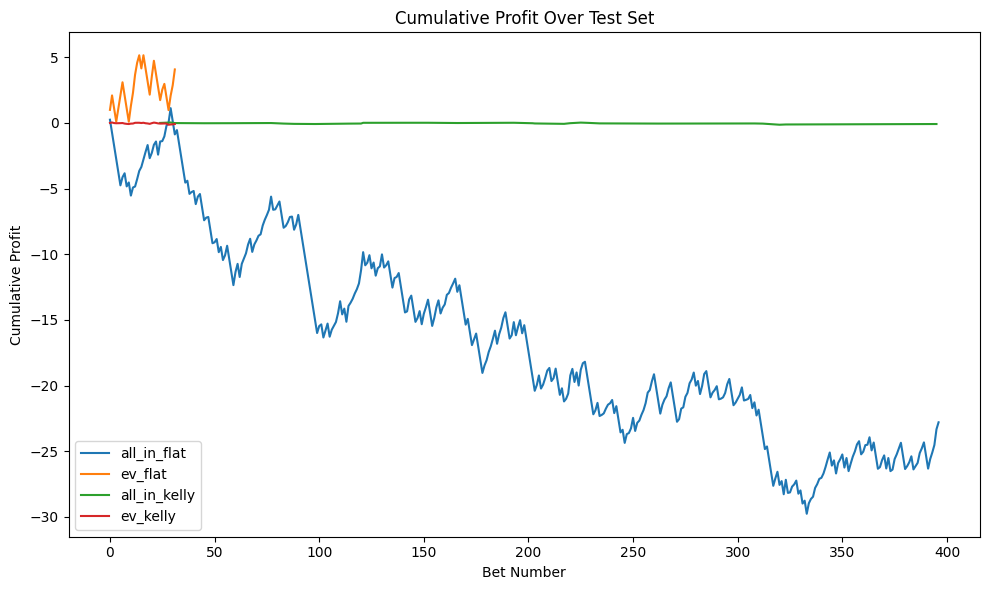

Overall MC: 100%|██████████| 1000/1000 [00:13<00:00, 76.71run/s, ev_kelly: 500/500]

Strategy      | Bust Probability
--------------------------------
ev_flat       | 70.40%
ev_kelly      | 0.00%


In [114]:
# 1) Load your kept feature list and your test DataFrame
with open("kept_features.pkl", "rb") as f:
    feature_cols = pickle.load(f)

final_model = XGBClassifier()
final_model.load_model("./models/xgb_model.json")
# 1) Parse to datetime (if not already)
final_dataset_odds['DATE'] = pd.to_datetime(
    final_dataset_odds['DATE'],
    format='%Y-%m-%d',
    errors='coerce'
)

# 2) Filter for 2025
YTD_data = final_dataset_odds[final_dataset_odds['DATE'].dt.year == 2025].copy()
# assume you’ve already merged in P1_ODDS/P2_ODDS and have an "actual" column
# where actual==1 means Player 1 won, and actual==0 means Player 2 won.
# e.g.:
# test_df = pd.read_csv("merged_test_with_odds.csv")
mapper = np.vectorize(lambda x: "Player 2 Wins" if x == 0 else "Player 1 Wins")
test_df_1 = YTD_data.reindex(columns=feature_cols, fill_value=0)
test_df = YTD_data
# Predict and map result
# 2) Compute model probabilities
probs = final_model.predict_proba(np.array(test_df_1, dtype=object))
test_df["pred_prob_p1"] = probs[:, 1]
test_df["pred_prob_p2"] = probs[:, 0]

# 3) For each match, pick the “chosen side” (model favorite)
test_df["chosen_side"] = np.where(
    test_df["pred_prob_p1"] >= 0.5, "P1", "P2"
)
test_df["chosen_prob"] = np.where(
    test_df["chosen_side"] == "P1", 
    test_df["pred_prob_p1"], 
    test_df["pred_prob_p2"]
)
test_df["chosen_odds"] = np.where(
    test_df["chosen_side"] == "P1", 
    test_df["P1_ODDS"], 
    test_df["P2_ODDS"]
)

# 4) Compute EV, b and q, and actual outcome on the chosen side
test_df["EV"] = test_df["chosen_odds"] * test_df["chosen_prob"] - 1.0
test_df["b"]  = test_df["chosen_odds"] - 1.0
test_df["q"]  = 1.0 - test_df["chosen_prob"]
# if chosen_side == P1, actual_chosen = actual; else = 1-actual
test_df["actual_chosen"] = np.where(
    test_df["chosen_side"] == "P1", 
    test_df["RESULT"], 
    1 - test_df["RESULT"]
)

# 5) Define staking functions (flat_stake now accepts bankroll)
def flat_stake(row, stake_size=1.0, bankroll=None, **kwargs):
    return stake_size

def kelly_stake(row, bankroll=100.0, fraction=0.25, **kwargs):
    p, b, q = row["chosen_prob"], row["b"], row["q"]
    f = (b*p - q) / b if b > 0 else 0.0
    return max(0.0, f) * bankroll * fraction

def simulate_sequential(df, stake_func, stake_kwargs=None, 
                        selection_rule=lambda d: d.index, 
                        bankroll_start=1.0):
    df = df.copy().reset_index(drop=True)
    stake_kwargs = stake_kwargs or {}

    # select which rows to bet on
    sel = selection_rule(df)
    df = df.loc[sel].reset_index(drop=True)

    # prepare lists
    stakes, profits, bankrolls, cum_profits = [], [], [], []
    bankroll = bankroll_start
    cum_profit = 0.0

    # iterate sequentially
    for _, row in df.iterrows():
        # compute stake using the *current* bankroll
        stake = stake_func(row, bankroll=bankroll, **stake_kwargs)
        stake = min(stake, 100)
        # compute profit
        profit = row["b"] * stake if row["actual_chosen"] == 1 else -stake
        # update bankroll
        bankroll += profit
        bankroll = min(bankroll, 10000)
        cum_profit += profit

        # record
        stakes.append(stake)
        profits.append(profit)
        bankrolls.append(bankroll)
        cum_profits.append(cum_profit)

    # assign back to DataFrame
    df["stake"]    = stakes
    df["profit"]   = profits
    df["bankroll"] = bankrolls
    df["cum_profit"] = cum_profits

    bet_df = df[df["stake"] > 0].copy()

    total_profit = bet_df["profit"].sum()
    total_staked = bet_df["stake"].sum()
    roi = total_profit / total_staked if total_staked > 0 else float("nan")
    
        # count wins & losses
    wins   = int((bet_df["profit"] > 0).sum())
    losses = int((bet_df["profit"] <= 0).sum())
    
    mean_pred_edge = bet_df["EV"].mean()
    std_pred_edge  = bet_df["EV"].std()
    # realized edge = profit/stake
    bet_df["realized_edge"] = bet_df["profit"]/bet_df["stake"]
    mean_real_edge = bet_df["realized_edge"].mean()
    std_real_edge  = bet_df["realized_edge"].std()

    return {
        "df": bet_df,
        "bets": len(bet_df),
        "wins": wins,
        "losses": losses,
        "profit": total_profit,
        "ROI": roi,
        "mean_pred_edge": mean_pred_edge,
        "std_pred_edge": std_pred_edge,
        "mean_real_edge": mean_real_edge,
        "std_real_edge": std_real_edge
    }



# 7) Define selection rules
sel_all = lambda d: d.index
sel_ev  = lambda d: d[d["EV"] > 0].index

# 8) Run your four scenarios using the new simulate_sequential()
results = {
    "all_in_flat":  simulate_sequential(test_df, flat_stake, {"stake_size":1.0}, sel_all),
    "ev_flat":      simulate_sequential(test_df, flat_stake, {"stake_size":1.0}, sel_ev),
    "all_in_kelly": simulate_sequential(test_df, kelly_stake, {"fraction":0.25}, sel_all),
    "ev_kelly":     simulate_sequential(test_df, kelly_stake, {"fraction":0.25}, sel_ev),
}

print("Strategy      | Bets | Wins | Losses |   ROI   | Pred Edge ±σ | Real Edge ±σ |   Profit   |")
print("------------------------------------------------------------------------------------------")
for name, r in results.items():
    print(f"{name:13s} | {r['bets']:4d} | {r['wins']:4d} | {r['losses']:6d} |"
          f" {r['ROI']:7.2%} |"
          f" {r['mean_pred_edge']:.4f}±{r['std_pred_edge']:.4f} |"
          f" {r['mean_real_edge']:.4f}±{r['std_real_edge']:.4f}"
          f" | {r['profit']:10.2f} |")

# 10) Breakdown by probability thresholds
prob_thrs = np.linspace(0.5, 0.9, 9)
prob_break = []
for thr in prob_thrs:
    sub = test_df[test_df["chosen_prob"] >= thr]
    if sub.empty: continue
    res = simulate_sequential(sub, flat_stake, {"stake_size":1.0}, lambda d: d.index)
    prob_break.append((thr, res["bets"], res["ROI"]))
prob_df = pd.DataFrame(prob_break, columns=["prob_thr","bets","ROI"])
print("\nROI by model-prob threshold:")
print(prob_df)

# 11) Breakdown by EV thresholds
ev_thrs = np.linspace(0, test_df["EV"].max(), 11)
ev_break = []
for thr in ev_thrs:
    sub = test_df[test_df["EV"] >= thr]
    if sub.empty: continue
    res = simulate_sequential(sub, flat_stake, {"stake_size":1.0}, lambda d: d.index)
    ev_break.append((thr, res["bets"], res["ROI"]))
ev_df = pd.DataFrame(ev_break, columns=["ev_thr","bets","ROI"])
print("\nROI by EV threshold:")
print(ev_df)

# 10) Plot cumulative profit curves
plt.figure(figsize=(10,6))
for name, r in results.items():
    plt.plot(r["df"]["cum_profit"], label=name)
plt.xlabel("Bet Number")
plt.ylabel("Cumulative Profit")
plt.title("Cumulative Profit Over Test Set")
plt.legend()
plt.tight_layout()
plt.show()

# 13) Function to run one sequential simulation and report minimum bankroll
def min_bankroll(df, stake_func, stake_kwargs, selection_rule, bankroll_start):
    res = simulate_sequential(df, stake_func, stake_kwargs, selection_rule, bankroll_start)
    return res["df"]["bankroll"].min()

# 14) Monte-Carlo estimate of bust probability with nested tqdm
def estimate_bust_prob(df, stake_func, stake_kwargs, selection_rule,
                       bankroll_start=1.0, runs=1000, seed=42):
    rng = np.random.default_rng(seed)
    busts = 0
    for _ in tqdm(range(runs), desc="MC runs", position=1, unit="run"):
        df_run = df.sample(frac=1, random_state=rng.integers(1e9))
        if min_bankroll(df_run, stake_func, stake_kwargs, selection_rule, bankroll_start) <= 0:
            busts += 1
    return busts / runs

strategies = [
    ("ev_flat",      flat_stake,  {"stake_size":1.0}, sel_ev),
    ("ev_kelly",     kelly_stake, {"fraction":1.0},  sel_ev),
]
runs = 500
total_runs = runs * len(strategies)

# prepare results dict
bust_results = {}

# one bar for everything
pbar = tqdm(total=total_runs, desc="Overall MC", unit="run")

for name, fn, kwargs, rule in strategies:
    busts = 0
    for i in range(runs):
        # update the description to show where we are
        pbar.set_postfix_str(f"{name}: {i+1}/{runs}")
        
        df_run = test_df.sample(frac=1, random_state=None).reset_index(drop=True)
        if min_bankroll(df_run, fn, kwargs, rule, bankroll_start=1.0) <= 0:
            busts += 1
        
        pbar.update(1)
    
    bust_results[name] = busts / runs

pbar.close()

# print results
print("Strategy      | Bust Probability")
print("--------------------------------")
for name, p in bust_results.items():
    print(f"{name:13s} | {p:.2%}")


In [115]:
for col in ["RESULT", "P1_ODDS", "P2_ODDS"]:
    test_df[col] = test_df.pop(col)
test_df.head(20)

,AGE_DIFF,ATP_POINTS_DIFF,ATP_RANK_DIFF,AVG_GAMES_SET1_DIFF,AVG_GAMES_SET1_P1,AVG_GAMES_SET1_P2,AVG_GAMES_SET2_DIFF,AVG_GAMES_SET2_P1,AVG_GAMES_SET2_P2,AVG_GAMES_SET3_DIFF,AVG_GAMES_SET3_P1,AVG_GAMES_SET3_P2,AVG_GAMES_SET4_DIFF,AVG_GAMES_SET4_P1,AVG_GAMES_SET4_P2,AVG_GAMES_SET5_DIFF,AVG_GAMES_SET5_P1,AVG_GAMES_SET5_P2,BEST_OF,CHAMPIONSHIPS_DIFF,CHAMPIONSHIPS_P1,CHAMPIONSHIPS_P2,DATE,DRAW_SIZE,ELO_DIFF,ELO_GRAD_LAST_100_DIFF,ELO_GRAD_LAST_10_DIFF,ELO_GRAD_LAST_200_DIFF,ELO_GRAD_LAST_25_DIFF,ELO_GRAD_LAST_3_DIFF,ELO_GRAD_LAST_50_DIFF,ELO_GRAD_LAST_5_DIFF,ELO_P1,ELO_P2,ELO_SURFACE_DIFF,ELO_SURFACE_P1,ELO_SURFACE_P2,H2H_DIFF,H2H_P1,H2H_P2,H2H_SURFACE_DIFF,H2H_SURFACE_P1,H2H_SURFACE_P2,HAS_PLAYED_CUR_LEVEL_P1,HAS_PLAYED_CUR_LEVEL_P2,HAS_PLAYED_CUR_TOURN_P1,HAS_PLAYED_CUR_TOURN_P2,HEIGHT_DIFF,MATCHES_LAST_1MO_P1,MATCHES_LAST_1MO_P2,MATCHES_LAST_1YR_P1,MATCHES_LAST_1YR_P2,MATCHES_LAST_3MO_P1,MATCHES_LAST_3MO_P2,MATCHES_LAST_6MO_P1,MATCHES_LAST_6MO_P2,MATCHES_PLAYED_P1,MATCHES_PLAYED_P2,N_GAMES_DIFF,P1_WINPROB,P2_WINPROB,PCT_WIN_CUR_LEVEL_P1,PCT_WIN_CUR_LEVEL_P2,PCT_WIN_CUR_TOURN_P1,PCT_WIN_CUR_TOURN_P2,P_1ST_IN_LAST_100_DIFF,P_1ST_IN_LAST_100_P1,P_1ST_IN_LAST_100_P2,P_1ST_IN_LAST_10_DIFF,P_1ST_IN_LAST_10_P1,P_1ST_IN_LAST_10_P2,P_1ST_IN_LAST_200_DIFF,P_1ST_IN_LAST_200_P1,P_1ST_IN_LAST_200_P2,P_1ST_IN_LAST_25_DIFF,P_1ST_IN_LAST_25_P1,P_1ST_IN_LAST_25_P2,P_1ST_IN_LAST_3_DIFF,P_1ST_IN_LAST_3_P1,P_1ST_IN_LAST_3_P2,P_1ST_IN_LAST_50_DIFF,P_1ST_IN_LAST_50_P1,P_1ST_IN_LAST_50_P2,P_1ST_IN_LAST_5_DIFF,P_1ST_IN_LAST_5_P1,P_1ST_IN_LAST_5_P2,P_1ST_WON_LAST_100_DIFF,P_1ST_WON_LAST_100_P1,P_1ST_WON_LAST_100_P2,P_1ST_WON_LAST_10_DIFF,P_1ST_WON_LAST_10_P1,P_1ST_WON_LAST_10_P2,P_1ST_WON_LAST_200_DIFF,P_1ST_WON_LAST_200_P1,P_1ST_WON_LAST_200_P2,P_1ST_WON_LAST_25_DIFF,P_1ST_WON_LAST_25_P1,P_1ST_WON_LAST_25_P2,P_1ST_WON_LAST_3_DIFF,P_1ST_WON_LAST_3_P1,P_1ST_WON_LAST_3_P2,P_1ST_WON_LAST_50_DIFF,P_1ST_WON_LAST_50_P1,P_1ST_WON_LAST_50_P2,P_1ST_WON_LAST_5_DIFF,P_1ST_WON_LAST_5_P1,P_1ST_WON_LAST_5_P2,P_2ND_WON_LAST_100_DIFF,P_2ND_WON_LAST_100_P1,P_2ND_WON_LAST_100_P2,P_2ND_WON_LAST_10_DIFF,P_2ND_WON_LAST_10_P1,P_2ND_WON_LAST_10_P2,P_2ND_WON_LAST_200_DIFF,P_2ND_WON_LAST_200_P1,P_2ND_WON_LAST_200_P2,P_2ND_WON_LAST_25_DIFF,P_2ND_WON_LAST_25_P1,P_2ND_WON_LAST_25_P2,P_2ND_WON_LAST_3_DIFF,P_2ND_WON_LAST_3_P1,P_2ND_WON_LAST_3_P2,P_2ND_WON_LAST_50_DIFF,P_2ND_WON_LAST_50_P1,P_2ND_WON_LAST_50_P2,P_2ND_WON_LAST_5_DIFF,P_2ND_WON_LAST_5_P1,P_2ND_WON_LAST_5_P2,P_ACE_DF_LAST_100_DIFF,P_ACE_DF_LAST_100_P1,P_ACE_DF_LAST_100_P2,P_ACE_DF_LAST_10_DIFF,P_ACE_DF_LAST_10_P1,P_ACE_DF_LAST_10_P2,P_ACE_DF_LAST_200_DIFF,P_ACE_DF_LAST_200_P1,P_ACE_DF_LAST_200_P2,P_ACE_DF_LAST_25_DIFF,P_ACE_DF_LAST_25_P1,P_ACE_DF_LAST_25_P2,P_ACE_DF_LAST_3_DIFF,P_ACE_DF_LAST_3_P1,P_ACE_DF_LAST_3_P2,P_ACE_DF_LAST_50_DIFF,P_ACE_DF_LAST_50_P1,P_ACE_DF_LAST_50_P2,P_ACE_DF_LAST_5_DIFF,P_ACE_DF_LAST_5_P1,P_ACE_DF_LAST_5_P2,P_ACE_LAST_100_DIFF,P_ACE_LAST_100_P1,P_ACE_LAST_100_P2,P_ACE_LAST_10_DIFF,P_ACE_LAST_10_P1,P_ACE_LAST_10_P2,P_ACE_LAST_200_DIFF,P_ACE_LAST_200_P1,P_ACE_LAST_200_P2,P_ACE_LAST_25_DIFF,P_ACE_LAST_25_P1,P_ACE_LAST_25_P2,P_ACE_LAST_3_DIFF,P_ACE_LAST_3_P1,P_ACE_LAST_3_P2,P_ACE_LAST_50_DIFF,P_ACE_LAST_50_P1,P_ACE_LAST_50_P2,P_ACE_LAST_5_DIFF,P_ACE_LAST_5_P1,P_ACE_LAST_5_P2,P_BP/RECG_LAST_100_DIFF,P_BP/RECG_LAST_100_P1,P_BP/RECG_LAST_100_P2,P_BP/RECG_LAST_10_DIFF,P_BP/RECG_LAST_10_P1,P_BP/RECG_LAST_10_P2,P_BP/RECG_LAST_200_DIFF,P_BP/RECG_LAST_200_P1,P_BP/RECG_LAST_200_P2,P_BP/RECG_LAST_25_DIFF,P_BP/RECG_LAST_25_P1,P_BP/RECG_LAST_25_P2,P_BP/RECG_LAST_3_DIFF,P_BP/RECG_LAST_3_P1,P_BP/RECG_LAST_3_P2,P_BP/RECG_LAST_50_DIFF,P_BP/RECG_LAST_50_P1,P_BP/RECG_LAST_50_P2,P_BP/RECG_LAST_5_DIFF,P_BP/RECG_LAST_5_P1,P_BP/RECG_LAST_5_P2,P_BP_CONVERTED_LAST_100_DIFF,P_BP_CONVERTED_LAST_100_P1,P_BP_CONVERTED_LAST_100_P2,P_BP_CONVERTED_LAST_10_DIFF,P_BP_CONVERTED_LAST_10_P1,P_BP_CONVERTED_LAST_10_P2,P_BP_CONVERTED_LAST_200_DIFF,P_BP_CONVERTED_LAST_200_P1,P_BP_CONVERTED_LAST_200_P2,P_BP_CONVERTED_LAST_25_DIFF,P_BP_CONV

In [116]:
accuracy = (test_df["PRED_B365"] == test_df["RESULT"]).mean()
print(f"Betting odds prediction accuracy: {accuracy:.3%}")

test_df["CHOSEN"] = np.where(test_df["chosen_side"] == "P1",
                            1, 0)
accuracy = (test_df["CHOSEN"] == test_df["RESULT"]).mean()
print(f"Betting odds prediction accuracy: {accuracy:.3%}")


Betting odds prediction accuracy: 65.239%
Betting odds prediction accuracy: 64.987%


In [118]:
test_df.to_csv("./data/predictions.csv", index=False)

In [111]:
check = pd.read_csv("./data/1finalDataset.csv")
check.tail(5)

,AGE_DIFF,ATP_POINTS_DIFF,ATP_RANK_DIFF,AVG_GAMES_SET1_DIFF,AVG_GAMES_SET1_P1,AVG_GAMES_SET1_P2,AVG_GAMES_SET2_DIFF,AVG_GAMES_SET2_P1,AVG_GAMES_SET2_P2,AVG_GAMES_SET3_DIFF,AVG_GAMES_SET3_P1,AVG_GAMES_SET3_P2,AVG_GAMES_SET4_DIFF,AVG_GAMES_SET4_P1,AVG_GAMES_SET4_P2,AVG_GAMES_SET5_DIFF,AVG_GAMES_SET5_P1,AVG_GAMES_SET5_P2,BEST_OF,CHAMPIONSHIPS_DIFF,CHAMPIONSHIPS_P1,CHAMPIONSHIPS_P2,DRAW_SIZE,ELO_DIFF,ELO_GRAD_LAST_100_DIFF,ELO_GRAD_LAST_10_DIFF,ELO_GRAD_LAST_200_DIFF,ELO_GRAD_LAST_25_DIFF,ELO_GRAD_LAST_3_DIFF,ELO_GRAD_LAST_50_DIFF,ELO_GRAD_LAST_5_DIFF,ELO_P1,ELO_P2,ELO_SURFACE_DIFF,ELO_SURFACE_P1,ELO_SURFACE_P2,H2H_DIFF,H2H_P1,H2H_P2,H2H_SURFACE_DIFF,H2H_SURFACE_P1,H2H_SURFACE_P2,HAS_PLAYED_CUR_LEVEL_P1,HAS_PLAYED_CUR_LEVEL_P2,HAS_PLAYED_CUR_TOURN_P1,HAS_PLAYED_CUR_TOURN_P2,HEIGHT_DIFF,MATCHES_LAST_1MO_P1,MATCHES_LAST_1MO_P2,MATCHES_LAST_1YR_P1,MATCHES_LAST_1YR_P2,MATCHES_LAST_3MO_P1,MATCHES_LAST_3MO_P2,MATCHES_LAST_6MO_P1,MATCHES_LAST_6MO_P2,MATCHES_PLAYED_P1,MATCHES_PLAYED_P2,N_GAMES_DIFF,P1_WINPROB,P2_WINPROB,PCT_WIN_CUR_LEVEL_P1,PCT_WIN_CUR_LEVEL_P2,PCT_WIN_CUR_TOURN_P1,PCT_WIN_CUR_TOURN_P2,P_1ST_IN_LAST_100_DIFF,P_1ST_IN_LAST_100_P1,P_1ST_IN_LAST_100_P2,P_1ST_IN_LAST_10_DIFF,P_1ST_IN_LAST_10_P1,P_1ST_IN_LAST_10_P2,P_1ST_IN_LAST_200_DIFF,P_1ST_IN_LAST_200_P1,P_1ST_IN_LAST_200_P2,P_1ST_IN_LAST_25_DIFF,P_1ST_IN_LAST_25_P1,P_1ST_IN_LAST_25_P2,P_1ST_IN_LAST_3_DIFF,P_1ST_IN_LAST_3_P1,P_1ST_IN_LAST_3_P2,P_1ST_IN_LAST_50_DIFF,P_1ST_IN_LAST_50_P1,P_1ST_IN_LAST_50_P2,P_1ST_IN_LAST_5_DIFF,P_1ST_IN_LAST_5_P1,P_1ST_IN_LAST_5_P2,P_1ST_WON_LAST_100_DIFF,P_1ST_WON_LAST_100_P1,P_1ST_WON_LAST_100_P2,P_1ST_WON_LAST_10_DIFF,P_1ST_WON_LAST_10_P1,P_1ST_WON_LAST_10_P2,P_1ST_WON_LAST_200_DIFF,P_1ST_WON_LAST_200_P1,P_1ST_WON_LAST_200_P2,P_1ST_WON_LAST_25_DIFF,P_1ST_WON_LAST_25_P1,P_1ST_WON_LAST_25_P2,P_1ST_WON_LAST_3_DIFF,P_1ST_WON_LAST_3_P1,P_1ST_WON_LAST_3_P2,P_1ST_WON_LAST_50_DIFF,P_1ST_WON_LAST_50_P1,P_1ST_WON_LAST_50_P2,P_1ST_WON_LAST_5_DIFF,P_1ST_WON_LAST_5_P1,P_1ST_WON_LAST_5_P2,P_2ND_WON_LAST_100_DIFF,P_2ND_WON_LAST_100_P1,P_2ND_WON_LAST_100_P2,P_2ND_WON_LAST_10_DIFF,P_2ND_WON_LAST_10_P1,P_2ND_WON_LAST_10_P2,P_2ND_WON_LAST_200_DIFF,P_2ND_WON_LAST_200_P1,P_2ND_WON_LAST_200_P2,P_2ND_WON_LAST_25_DIFF,P_2ND_WON_LAST_25_P1,P_2ND_WON_LAST_25_P2,P_2ND_WON_LAST_3_DIFF,P_2ND_WON_LAST_3_P1,P_2ND_WON_LAST_3_P2,P_2ND_WON_LAST_50_DIFF,P_2ND_WON_LAST_50_P1,P_2ND_WON_LAST_50_P2,P_2ND_WON_LAST_5_DIFF,P_2ND_WON_LAST_5_P1,P_2ND_WON_LAST_5_P2,P_ACE_DF_LAST_100_DIFF,P_ACE_DF_LAST_100_P1,P_ACE_DF_LAST_100_P2,P_ACE_DF_LAST_10_DIFF,P_ACE_DF_LAST_10_P1,P_ACE_DF_LAST_10_P2,P_ACE_DF_LAST_200_DIFF,P_ACE_DF_LAST_200_P1,P_ACE_DF_LAST_200_P2,P_ACE_DF_LAST_25_DIFF,P_ACE_DF_LAST_25_P1,P_ACE_DF_LAST_25_P2,P_ACE_DF_LAST_3_DIFF,P_ACE_DF_LAST_3_P1,P_ACE_DF_LAST_3_P2,P_ACE_DF_LAST_50_DIFF,P_ACE_DF_LAST_50_P1,P_ACE_DF_LAST_50_P2,P_ACE_DF_LAST_5_DIFF,P_ACE_DF_LAST_5_P1,P_ACE_DF_LAST_5_P2,P_ACE_LAST_100_DIFF,P_ACE_LAST_100_P1,P_ACE_LAST_100_P2,P_ACE_LAST_10_DIFF,P_ACE_LAST_10_P1,P_ACE_LAST_10_P2,P_ACE_LAST_200_DIFF,P_ACE_LAST_200_P1,P_ACE_LAST_200_P2,P_ACE_LAST_25_DIFF,P_ACE_LAST_25_P1,P_ACE_LAST_25_P2,P_ACE_LAST_3_DIFF,P_ACE_LAST_3_P1,P_ACE_LAST_3_P2,P_ACE_LAST_50_DIFF,P_ACE_LAST_50_P1,P_ACE_LAST_50_P2,P_ACE_LAST_5_DIFF,P_ACE_LAST_5_P1,P_ACE_LAST_5_P2,P_BP/RECG_LAST_100_DIFF,P_BP/RECG_LAST_100_P1,P_BP/RECG_LAST_100_P2,P_BP/RECG_LAST_10_DIFF,P_BP/RECG_LAST_10_P1,P_BP/RECG_LAST_10_P2,P_BP/RECG_LAST_200_DIFF,P_BP/RECG_LAST_200_P1,P_BP/RECG_LAST_200_P2,P_BP/RECG_LAST_25_DIFF,P_BP/RECG_LAST_25_P1,P_BP/RECG_LAST_25_P2,P_BP/RECG_LAST_3_DIFF,P_BP/RECG_LAST_3_P1,P_BP/RECG_LAST_3_P2,P_BP/RECG_LAST_50_DIFF,P_BP/RECG_LAST_50_P1,P_BP/RECG_LAST_50_P2,P_BP/RECG_LAST_5_DIFF,P_BP/RECG_LAST_5_P1,P_BP/RECG_LAST_5_P2,P_BP_CONVERTED_LAST_100_DIFF,P_BP_CONVERTED_LAST_100_P1,P_BP_CONVERTED_LAST_100_P2,P_BP_CONVERTED_LAST_10_DIFF,P_BP_CONVERTED_LAST_10_P1,P_BP_CONVERTED_LAST_10_P2,P_BP_CONVERTED_LAST_200_DIFF,P_BP_CONVERTED_LAST_200_P1,P_BP_CONVERTED_LAST_200_P2,P_BP_CONVERTED_LAST_25_DIFF,P_BP_CONVERTED

## Why you should not bet using my model?
Firstly, I'm just a youtuber and a CS student. Also, this was a two/three week long project.
Bookmakers are cracked, and they have the best models, which they keep a secret. I doubt that my model will ever be able to compete with them.
That being said, I think this is a fun project about how you can use Machine Learning to do some pretty cool things. Also, this model could be improved in a lot of ways, which I will briefly explain below.

I hope you enjoyed!

## To Imporve
- Take into account when a player is injured or takes a break
    - Vary K ELO factor
    - Drop ELO points if abssence
- Do further analysis on the PCA and visualize better the data to observe patterns
- Calculate more stats
    - Calculate Average ELO Rating at last tournament
    - Average ELO opponent won vs Average ELO opponent lost
    - Check regularity of a player by checking upset percentage
    - Check regularity of a player by checking 
    - Calculate the probability of win from ELO depending on best of 3 or best of 5
        - https://github.com/JeffSackmann/tennis_misc/blob/master/fiveSetProb.py
- Train on last ten/five years - Less data, but more recent
- See if probabilites of XGBoost would be better than betting odds (highly unlikely)

## Resources
- https://www.tennisabstract.com/blog/2019/12/03/an-introduction-to-tennis-elo/
- https://github.com/JeffSackmann/tennis_misc/blob/master/fiveSetProb.py
- https://github.com/JeffSackmann/tennis_atp